# Deep Gaussian Process Regression Model

This notebook demonstrates the use of a deep GP model in MXFusion.

In [1]:
import mxfusion
import numpy as np
from mxfusion.common import config
config.DEFAULT_DTYPE = 'float64'

/Users/marpulli/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import mxnet as mx
import mxfusion.components.distributions.gp.kernels
from mxfusion.components.variables import PositiveTransformation
from mxfusion.modules.gp_modules.dgp import DeepGPRegression

N = 50
M = 10
m = mxfusion.Model()
m.N = mxfusion.Variable()
m.X = mxfusion.Variable(shape=(m.N, 1))
m.Z_0 = mxfusion.Variable(shape=(M, 1), initial_value=mx.nd.array(np.linspace(-5, 5, 10)[:, None]))
m.Z_1 = mxfusion.Variable(shape=(M, 1), initial_value=mx.nd.array(np.linspace(-5, 5, 10)[:, None]))
m.noise_var = mxfusion.Variable(transformation=PositiveTransformation())
kernels = [mxfusion.distributions.gp.kernels.RBF(1), mxfusion.distributions.gp.kernels.RBF(1)]
m.Y = DeepGPRegression.define_variable(m.X, kernels, m.noise_var, shape=(m.N, 1), inducing_inputs=[m.Z_0, m.Z_1])

In [3]:
X = np.linspace(-5, 5, N)[:, None]
Y = (X > 0).astype(float)

In [11]:
import mxnet as mx
from mxfusion.inference import GradBasedInference, MAP

infr = GradBasedInference(inference_algorithm=MAP(model=m, observed=[m.X, m.Y]))
infr.run(X=mx.nd.array(X, dtype='float64'), Y=mx.nd.array(Y, dtype='float64'), 
         max_iter=200, learning_rate=0.05, verbose=True)

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


Iteration 21 loss: 60.215334070653634
Iteration 41 loss: 46.926245290273395
Iteration 61 loss: 29.988912957926367
Iteration 81 loss: 18.951975014651905
Iteration 101 loss: 13.210781864051802
Iteration 121 loss: -5.9306193490890546
Iteration 141 loss: -29.748417196997438
Iteration 161 loss: -27.499797892983675
Iteration 181 loss: -52.394473319133415
Iteration 200 loss: -57.965628753503084

In [12]:
from mxfusion.inference import TransferInference, ModulePredictionAlgorithm
infr_pred = TransferInference(ModulePredictionAlgorithm(model=m, observed=[m.X], target_variables=[m.Y]), 
                              infr_params=infr.params)

In [13]:
xt = np.linspace(-5,5,50)[:, None]
res = infr_pred.run(X=mx.nd.array(xt, dtype='float64'))[0]
f_mean, f_var = res[0].asnumpy()[0], res[1].asnumpy()[0]

/Users/marpulli/git/MXFusion/mxfusion/inference/inference_parameters.py:74: UserWarning: InferenceParameters has already been initialized.  The existing one will be overwritten.
  warnings.warn("InferenceParameters has already been initialized.  The existing one will be overwritten.")


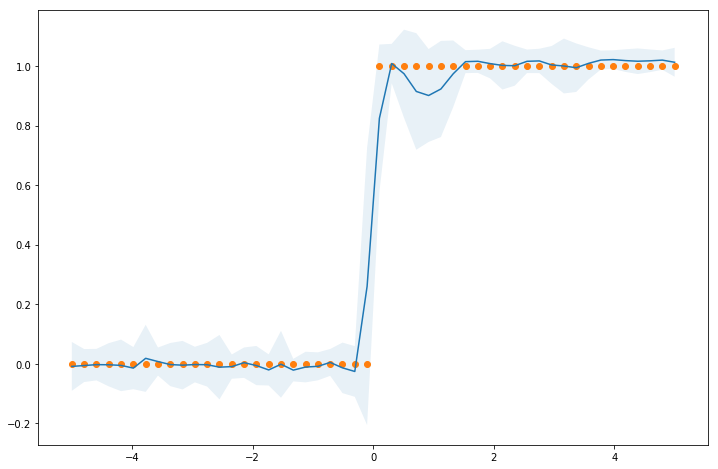

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

mean = res[0].asnumpy()[:, 0]
plt.plot(xt, res[0].asnumpy())

std = np.sqrt(res[1].asnumpy())[:, 0]
plt.fill_between(xt[:, 0], mean - std, mean + std, alpha=0.1)
plt.scatter(X, Y)